#Импорт нужных библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import sktime
except:
    !pip install sktime
    !pip install tsfresh
    !pip install numba
    !pip install llvmlite
import sktime
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split

#Импорт данных

In [ ]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

# Выбор данных для предсказания

In [ ]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
#     df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

### Для анализа возьмем потребление солнечной энергии во франции

In [ ]:
df_hrly = extract_country(df_all, country_code='FR', year_min=2015, year_max=2019)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

df.to_csv('de_clf_data.csv')

Уберем из  индексов временные зоны

In [ ]:
df.reset_index(inplace=True )
df['Date'] = df['Date'].dt.tz_convert(None)
df.set_index('Date', inplace=True)

# Анализ данных

In [ ]:
df

,Consumption,Solar
Date,,
2015-01-01 08:00:00,64.277,0.385
2015-01-01 09:00:00,65.100,1.053
2015-01-01 10:00:00,65.875,1.635
2015-01-01 11:00:00,67.460,1.883
2015-01-01 12:00:00,65.706,1.857
...,...,...
2019-12-31 19:00:00,64.771,0.000
2019-12-31 20:00:00,62.259,0.000
2019-12-31 21:00:00,63.774,0.000


Посмотрим как распределены данные на графике

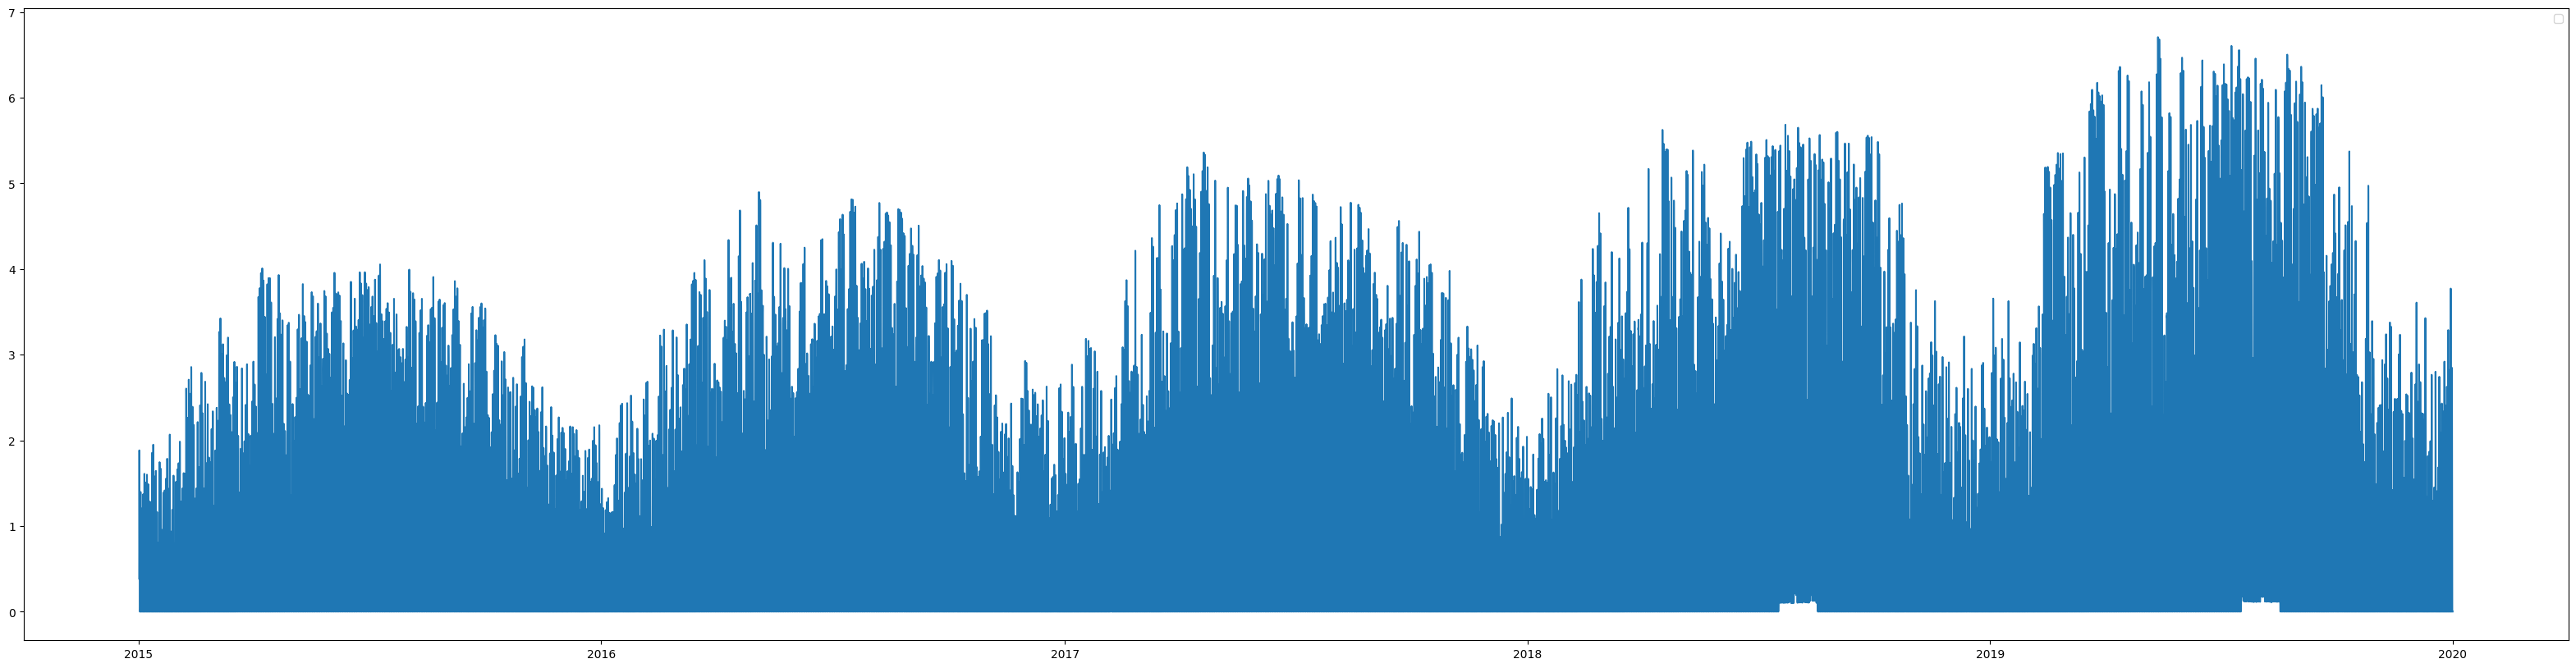

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(df["Solar"])
plt.legend(loc="best")
plt.show()
plt.close()

На графике можно увидеть сезонность. С начала до середины года потребление солнечной энергии плавно вырастает, а затем к концу года падает. Также можно заметить, что потребление солнечной ээнергии растет из года в год.

Посмотрим на данные с шагом в 7 дней

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Solar'>)

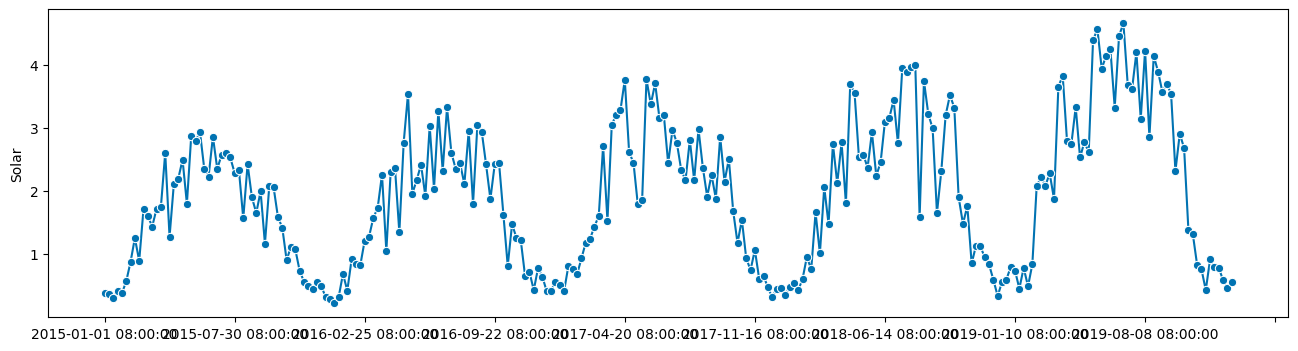

In [ ]:
y = df.Solar.asfreq('7d')
sktime.utils.plotting.plot_series(y)

#Методы предсказания значений ВР

Установим необходимые библиотеки для предсказания ВР

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

from math import sqrt
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric=True)
mse = MeanSquaredError()

Разделим данные на тренировочные и тестовые

Check splitted data size: Train: 183, Test: 78


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Solar'>)

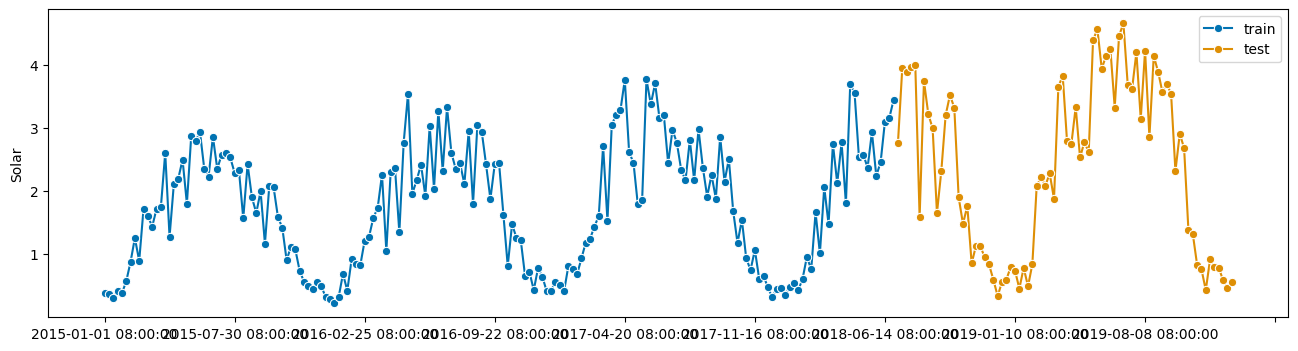

In [ ]:
TEST_SIZE = int(0.3*y.size)

train_data, test_data = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {train_data.shape[0]}, Test: {test_data.shape[0]}')

sktime.utils.plotting.plot_series(train_data, test_data, labels=["train", "test"])

##Наивное предсказание

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

RMSE = 1.7170830662522578


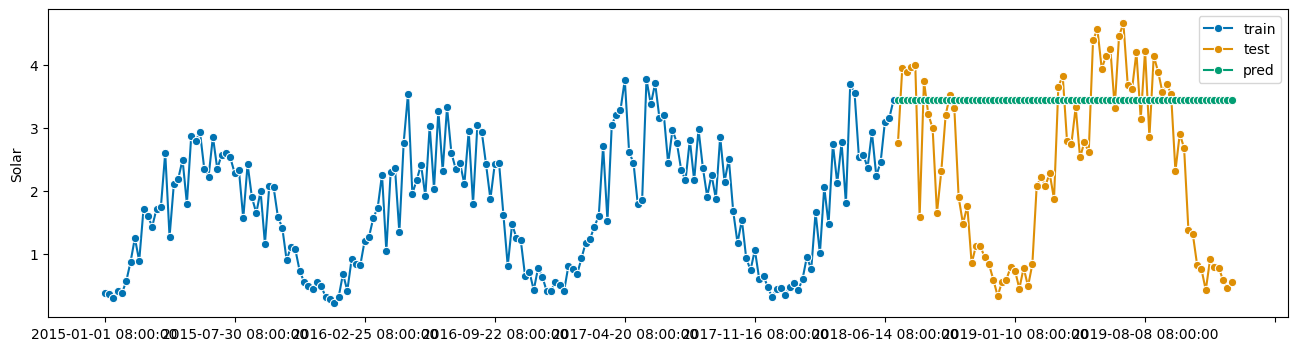

In [ ]:
fh = ForecastingHorizon(test_data.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(train_data)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(train_data, test_data, y_pred, labels=["train", "test", "pred"])

# ОШИБКА
rmse = sqrt(mse(test_data, y_pred))
print("RMSE = " + str(rmse))

Из значения RMSE и приведенного выше графика можно сделать вывод, что наивный метод не подходит для наборов данных с высокой изменчивостью. Он лучше всего подходит для стабильных наборов данных.

Так как в данных имеется сезонная составляющая оценим точность наивного сезонного предсказания.

RMSE = 0.9857343677973481


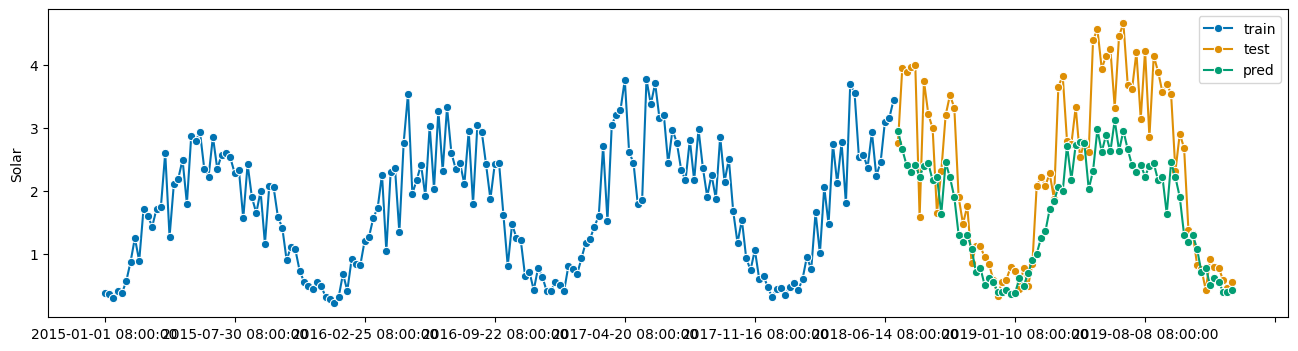

In [ ]:
SEASON = 52

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(train_data)

y_pred = forecaster.predict(fh)

plot_series(train_data, test_data, y_pred, labels=["train", "test", "pred"])

# ОШИБКА
rmse = sqrt(mse(test_data, y_pred))
print("RMSE = " + str(rmse))

Как можно заметить точность стала лучше, но все-равно далека от идеала

## Рассмотрим метод Prophet.

In [ ]:
from sktime.forecasting.fbprophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeu5ufjw0/pzwqo2m_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeu5ufjw0/4nixqc1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2826', 'data', 'file=/tmp/tmpeu5ufjw0/pzwqo2m_.json', 'init=/tmp/tmpeu5ufjw0/4nixqc1_.json', 'output', 'file=/tmp/tmpeu5ufjw0/prophet_model7rvk5284/prophet_model-20231116133520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE = 0.7704947737989019


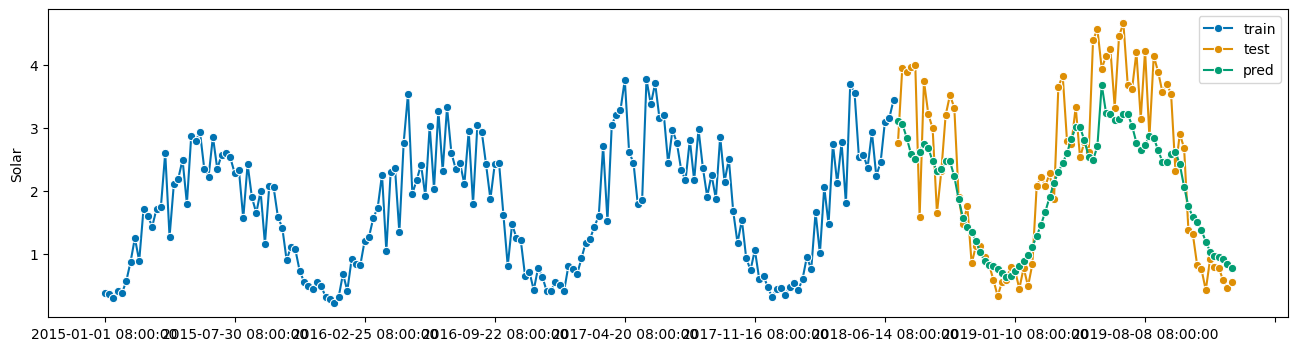

In [ ]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(train_data) / 4),
                    add_country_holidays={'country_name': 'France'},
                    yearly_seasonality=True)

forecaster.fit(train_data)
fh = ForecastingHorizon(test_data.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(train_data, test_data, y_pred, labels=["train", "test", "pred"])

# ОШИБКА
rmse = sqrt(mse(test_data, y_pred))
print("RMSE = " + str(rmse))

Метод Prophet показал результат чуть лучше чем наивное сезонное предсказание, также в предсказанных значениях имеется тренд, но точность недостаточно хороша.

## Метод XGBoost

In [ ]:
import xgboost as xgb

Выделим из дат необходимые модели признаки

In [ ]:
def create_features(data):
    """
    Creates time series features from datetime index
    """
    ds = pd.DataFrame(data)
    ds['date'] = ds.index
    ds['hour'] = ds['date'].dt.hour
    ds['dayofweek'] = ds['date'].dt.dayofweek
    ds['quarter'] = ds['date'].dt.quarter
    ds['month'] = ds['date'].dt.month
    ds['year'] = ds['date'].dt.year
    ds['dayofyear'] = ds['date'].dt.dayofyear
    ds['dayofmonth'] = ds['date'].dt.day
    ds['weekofyear'] = ds['date'].dt.weekofyear

    ds.drop('date', axis=1, inplace=True)

    X = ds.drop('Solar', axis=1)
    y = ds['Solar']

    return X, y

In [ ]:
X_train, y_train = create_features(train_data)
X_test, y_test = create_features(test_data)

<ipython-input-30-f908983a8995>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  ds['weekofyear'] = ds['date'].dt.weekofyear
<ipython-input-30-f908983a8995>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  ds['weekofyear'] = ds['date'].dt.weekofyear


Обучим модель

In [ ]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Посмотрим на признаки, которые имеют самый большой вклад в предсказание

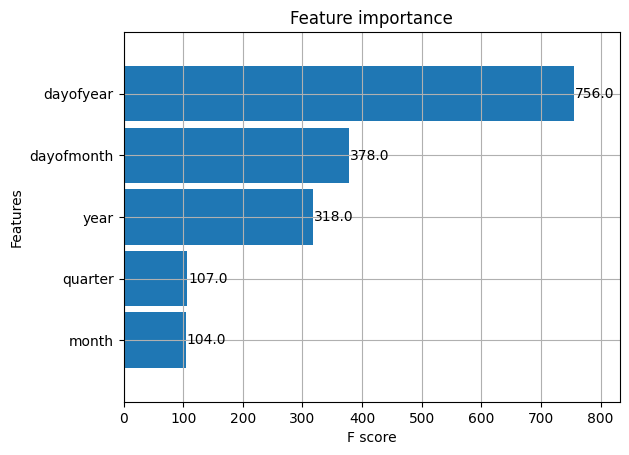

In [ ]:
_ = xgb.plot_importance(reg, height=0.9)

Самый большой вклад в предсказание имеет признак - день в году.

/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


RMSE = 0.8676579597275144


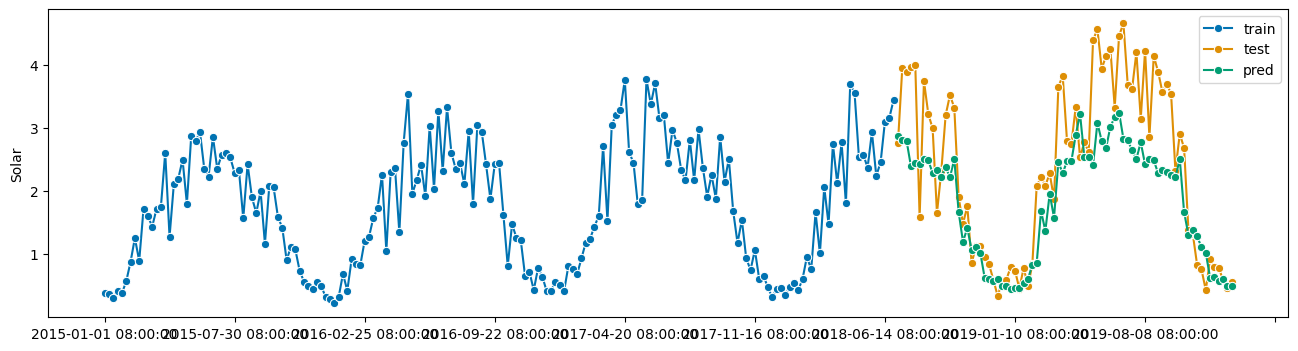

In [ ]:
y_pred = reg.predict(X_test)
pred_data = pd.Series(y_pred, index=test_data.index)
plot_series(train_data, test_data, pred_data, labels=["train", "test", "pred"])

# ОШИБКА
rmse = sqrt(mse(test_data, y_pred))
print("RMSE = " + str(rmse))

Судя по графику и выбранной мной метрике можно сказать, что модель XGBoost также как и Prophet предсказывает далеко не идеально.

## Итог для выбранных моделей

|model                        |Score RMSE|
|-----------------------------|----------|
|Наивное предсказание         |1.717     |
|Наивное сезонное предсказания|0.985     |
|Prophet                      |0.770     |
|XGBoost                      |0.867     |

Из данных методов наилучший результат показал метод Prophet

#SARIMA

##Установка необходимых библиотек

In [ ]:
!pip install pmdarima
import pmdarima as pm

In [ ]:
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller


import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

##Проведем диференцирование

Проверим ряд на стационарность, для этого будем использовать Расширенный тест Дики-Фуллера

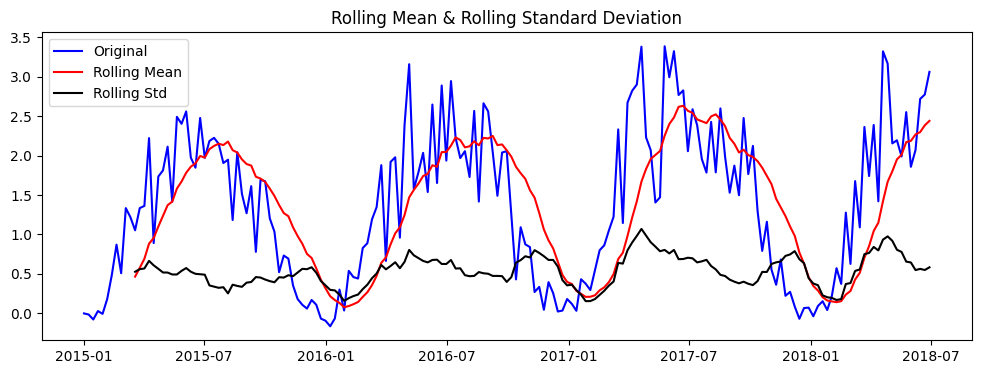

In [ ]:
rolling_mean = train_data.rolling(window = 12).mean()
rolling_std  = train_data.rolling(window = 12).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(train_data-train_data[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-train_data[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')

In [ ]:
check_ADF(train_data, p_threshold = P_THRESHOLD)

ADF Statistic: -4.7924
p-value: 0.0001
Critical Values:
	1%: -3.4696, 
	5%: -2.8788, 
	10%: -2.5760, 
Result: The series is not stationary


В данной ситуации оказалось так, что ряд не стационарен. В этом случае попробуем добиться стационарности через дифференцирование

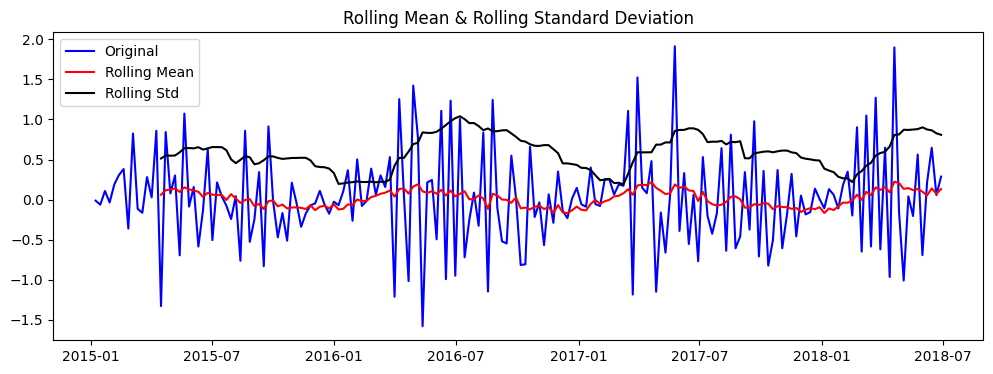

ADF Statistic: -12.9697
p-value: 0.0000
Critical Values:
	1%: -3.4672, 
	5%: -2.8777, 
	10%: -2.5754, 
Result: The series is not stationary


In [ ]:
y_diff = train_data[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

В ряду продолжает преобладает сезонная составляющая ряд остается по прежнему не стационарен.

Попробуем использовать сезонное дифференцирование

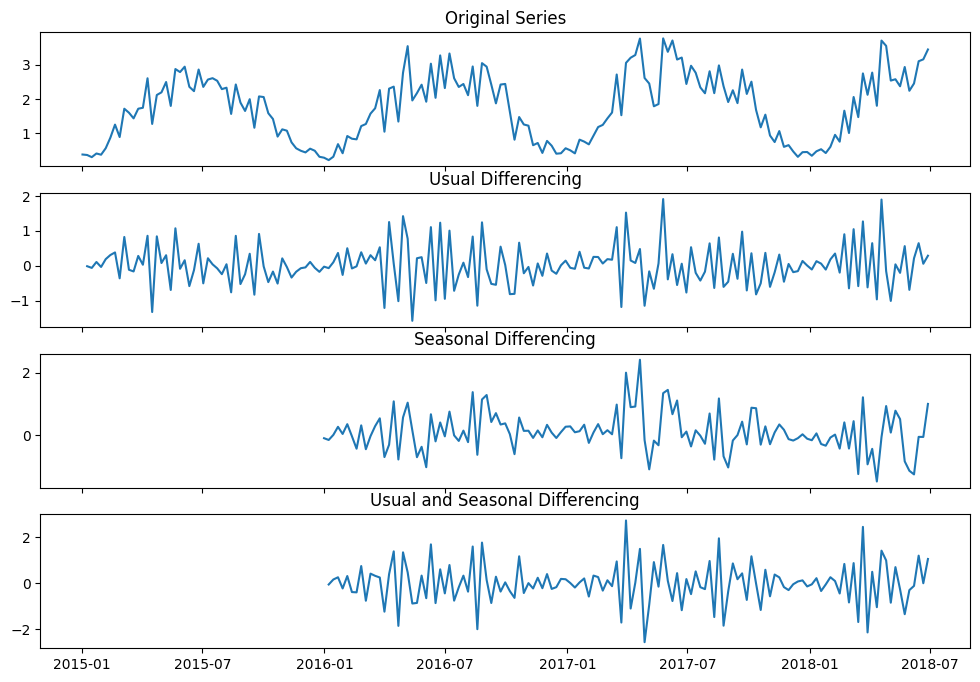

In [ ]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(train_data[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(train_data[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(train_data[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(train_data[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.show()

Сезонное дифференцирование немного улучшило ситуацию, но ряд все-равно далек от стационарного

In [ ]:
y_sdif = train_data[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -9.1562
p-value: 0.0000
Critical Values:
	1%: -3.4847, 
	5%: -2.8853, 
	10%: -2.5795, 
Result: The series is not stationary


К сожалению тест не дал того, что мы хотели. В данном случае можно заключить что предварительной оценкой порядков дифференцирования являются: d=1, D=1, s=52.

Далее перейдем к оценке порядков авторегрессии и скользящего среднего.

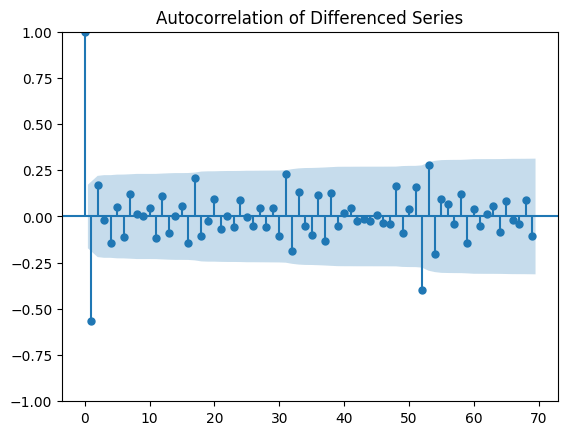

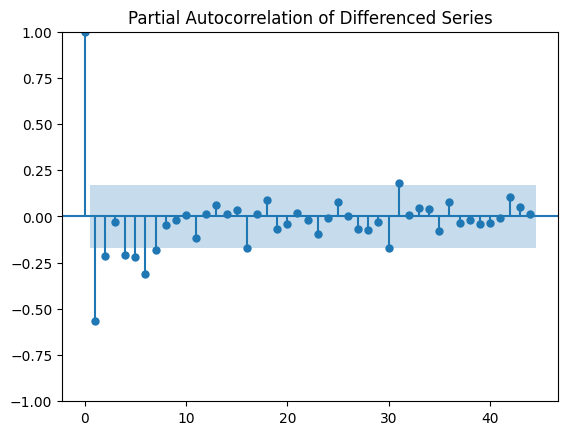

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y_sdif, title='Autocorrelation of Differenced Series', lags=np.arange(70))
plt.show()
# Usual Differencing
plot_pacf(y_sdif, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(45))
plt.show()

Из графиков выше следует следующий выбор параметров:
- Из гарфика PACF видно, что порядок AR будет p=3. Так как третий лаг - последний значимый;
- По ACF видно, что порядок MA q = 0;
- 0 порядок SAR - на PACF нет значимых лагов выше нуля;
- 0 порядок SMA - на ACF нет значимых лагов ниже нуля;
- Ряд немного недодифференцирован, поэтому установим 4 порядок AR;

Проверим модель SARIMA(4,1,0)(0,1,0)52

In [ ]:
forecaster = SARIMAX(order=(4, 1, 0), seasonal_order=(0, 1, 0, 52))
forecaster.fit(train_data)
print(forecaster.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Solar   No. Observations:                  183
Model:             SARIMAX(4, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -137.994
Date:                            Thu, 16 Nov 2023   AIC                            287.989
Time:                                    19:24:20   BIC                            305.194
Sample:                                01-01-2015   HQIC                           294.980
                                     - 06-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.064      0.065      0.948      -0.122       0.130
ar.L1         -0.7199      0.076   

##Проведем диагностику остатков

In [ ]:
#from scipy.stats import distributions

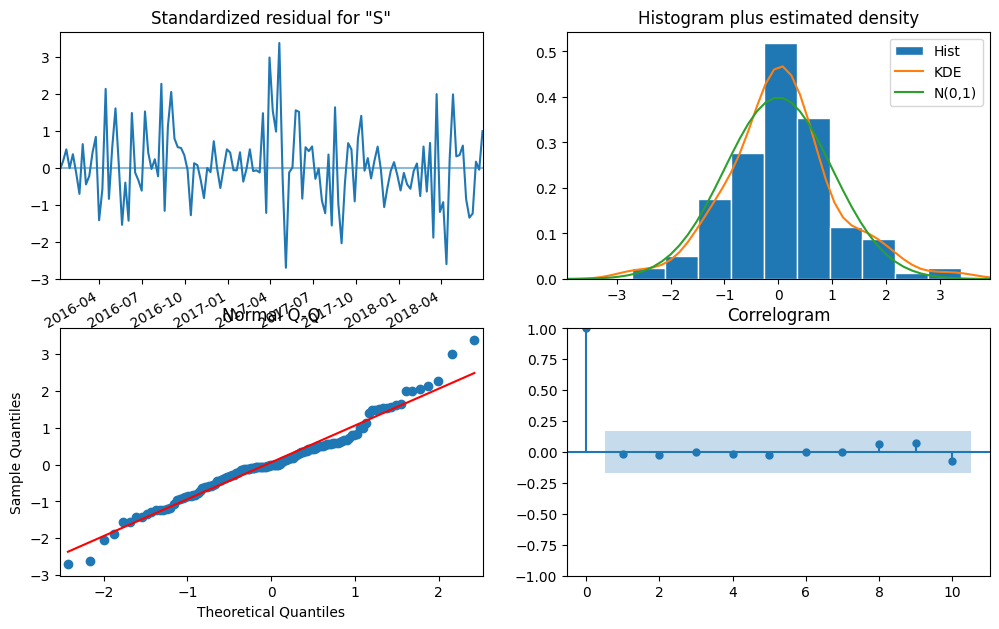

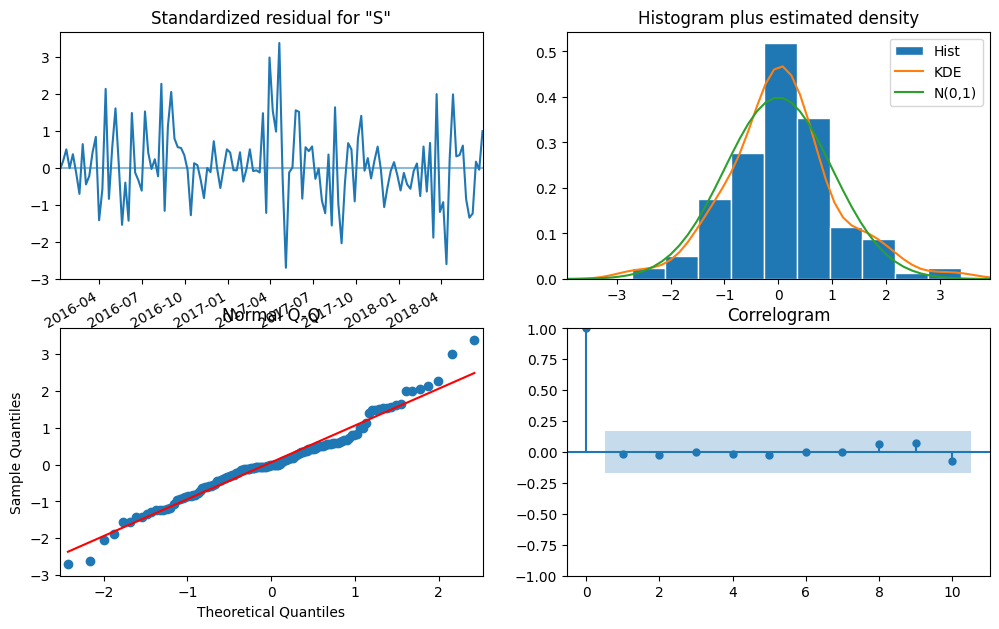

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8))

На графиках выше можно увидеть:

- верхний левый график: остаточные ошибки колеблются около нулевого среднего, однако имеют несколько не равномерную дисперсию, возможно модель недодифференцирована.
- верхний правый график: остаток имеет распределение, похожее на нормальное распределение.
- нижний левый график: график Q-Q показывает распределение, близкое к нормальному.
- нижний правый график: автокорреляционная функция не показывает значительных отличий от нормального распределения.

##Визуализируем предсказания модели

RMSE = 0.7976523056655761


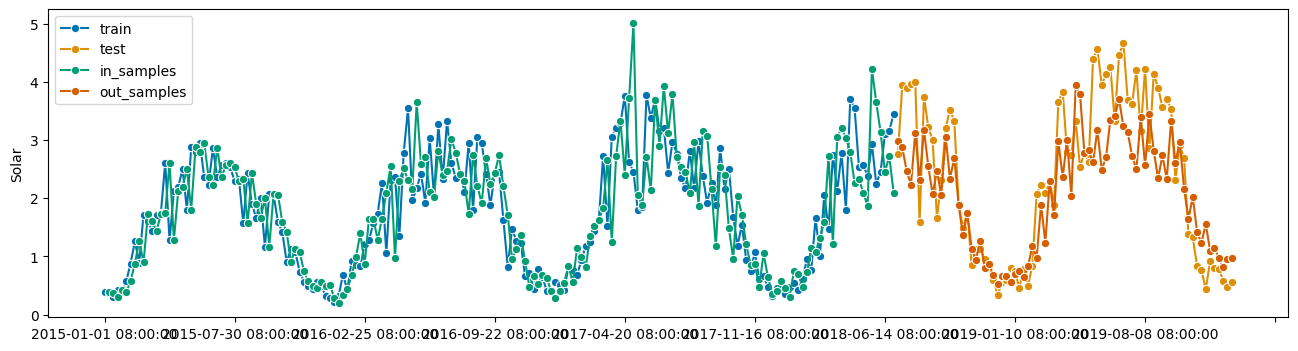

In [ ]:
fhin = ForecastingHorizon(train_data.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(test_data.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(train_data, test_data, y_in_samples, y_out, labels=["train", "test", "in_samples", "out_samples"])

rmse = sqrt(mse(test_data, y_out))
print("RMSE = " + str(rmse))

# Сравнение регрессионных моделей

|model                        |Score RMSE|
|-----------------------------|----------|
|Наивное предсказание         |1.717     |
|Наивное сезонное предсказания|0.985     |
|Prophet                      |0.770     |
|XGBoost                      |0.867     |
|Sarimax                      |0.797     |

Модель Sarimax показала наиболее близкий результат RMSE модели Prophet, в отличии от всех моделей.

#Классификация данных

## Подготовим данные для классификации

Разделим данные на 4 класса: зима, лето, осень, весна

In [ ]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)


In [ ]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Solar', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Solar', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Solar', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Solar', size = 24)


Посмотрим на распределение данных по каждому классу

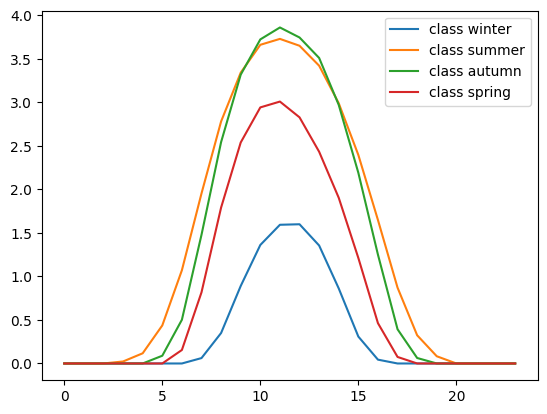

In [ ]:
plt.figure()
day = 5
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Давольно логичные получились показатели. Летом и осенью закономерно потребление солнечной энергии выше

## Попытка классифицировать разными моделями

Разделим данные на тренироваочные и тестовые

In [ ]:
X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1455, 24) (1455,) (364, 24) (364,)


In [ ]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ")
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ")

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.898
 test score 0.816


### KNeighborsTimeSeriesClassifier

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.701


In [ ]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.701


### ShapeletTransformClassifier

In [ ]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.854


### Сравнение методов классификации

|model                         |Score RMSE|
|------------------------------|----------|
|RandomForestClassifier        |0.898     |
|KNeighborsTimeSeriesClassifier|0.701     |
|ShapeletTransformClassifier   |0.854     |

# Tsai

Импортируем необходимые библиотеки

In [ ]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
from sklearn.model_selection import train_test_split
import torch
from torch import nn

Сопоставим названия классов и их номера для большего удобства

In [ ]:
X = np.atleast_3d(X).transpose(0,2,1)
class_map = {
    1:'winter',
    2:'summer',
    3:'autumn',
    4:'spring',
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y)

Создадим их разделение на тренировочную, валидационную и тестовую выборки.

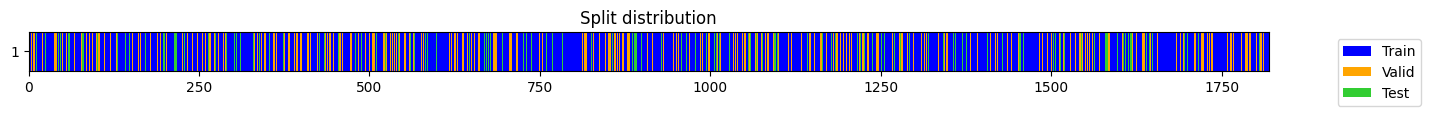

((#1275) [1472,281,591,190,614,159,407,459,1492,833...],
 (#363) [1710,850,1057,1487,102,1218,878,504,1093,1420...],
 (#181) [691,310,768,646,80,674,452,598,1220,1406...])

In [ ]:
splits = get_splits(y,
                    n_splits=1,
                    valid_size=0.2,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits

Сконфигурируем загрузчик батчей TSDataLoaders. Загрузим тренировочный и валидационный наборы данных.

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

Выберем необходимые архитектуры

In [ ]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),
         (LSTM,    {'n_layers':3, 'bidirectional': False}),
         (RNN,     {'n_layers':3, 'bidirectional': True} ),
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),
         (ResNet, {}),
         (InceptionTime, {}),
         (XceptionTime,  {}),
         (TCN, {}),
         (LSTM_FCN, {}),
         (TST, {}),
         (FCN, {}),
        ]

Оценим каждую модель

In [ ]:
from IPython.display import clear_output

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):

    model = create_model(arch, dls=dls, **k)

    print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142204,0.641392,0.418392,0.853994,13
1,ResNet,{},478724,0.381928,0.297070,0.853994,29
2,InceptionTime,{},388868,0.405250,0.338049,0.845730,49
3,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202604,0.556452,0.372242,0.842975,15
4,RNN,"{'n_layers': 3, 'bidirectional': True}",142204,0.646299,0.425747,0.837466,10
5,TST,{},411524,0.448272,0.335252,0.837466,36
6,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71304,0.629289,0.434671,0.834711,6
7,XceptionTime,{},399480,0.782371,0.734956,0.809917,89
8,LSTM_FCN,{},315380,0.673325,0.511079,0.796143,17
9,FCN,{},264580,0.646212,0.512102,0.790634,16


Самый хороший резульат показала архитектура RNNPlus c параметрами n_layers: 3, bidirectional: True. Данная архитектура показала самые оптимальные резултаты точности и времени работы

Рассмотрим данную архитектуру подробнее

In [ ]:
arch = RNNPlus
k = {'n_layers': 3, 'bidirectional': True}
model = build_ts_model(arch, arch_config=k, dls=dls)

Попробуем определить лучшую скорость обучения для данной архитектуры

SuggestedLRs(valley=0.0003981071640737355)

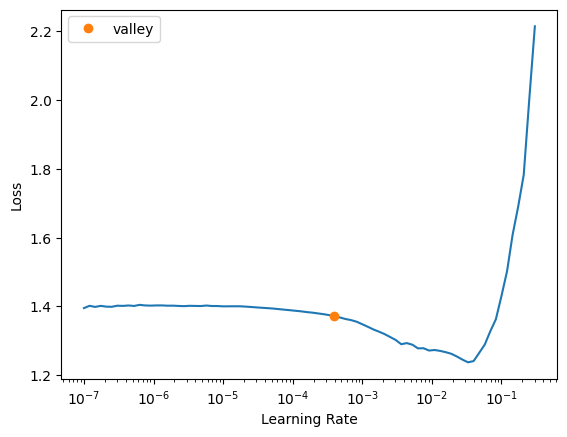

In [ ]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

Снова запустим обучение с учетом найденной скорости обучения

epoch,train_loss,valid_loss,accuracy,time
0,1.397098,1.386985,0.360882,00:01
1,1.390221,1.373297,0.363636,00:00
2,1.384923,1.359734,0.366391,00:00
3,1.377852,1.346971,0.380165,00:00
4,1.370550,1.334690,0.391185,00:00
5,1.363495,1.321451,0.388430,00:00
6,1.356575,1.303498,0.388430,00:00
7,1.348170,1.279297,0.391185,00:00
8,1.338963,1.252383,0.545455,00:00
9,1.327346,1.219350,0.531680,00:00


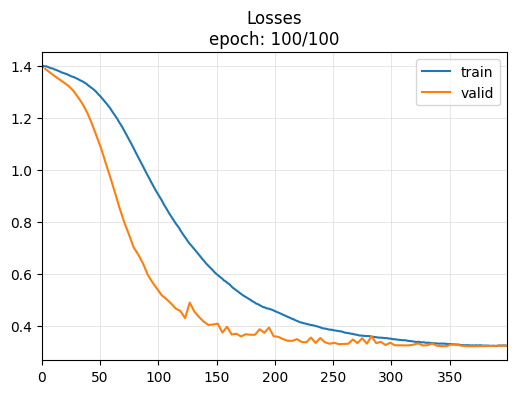

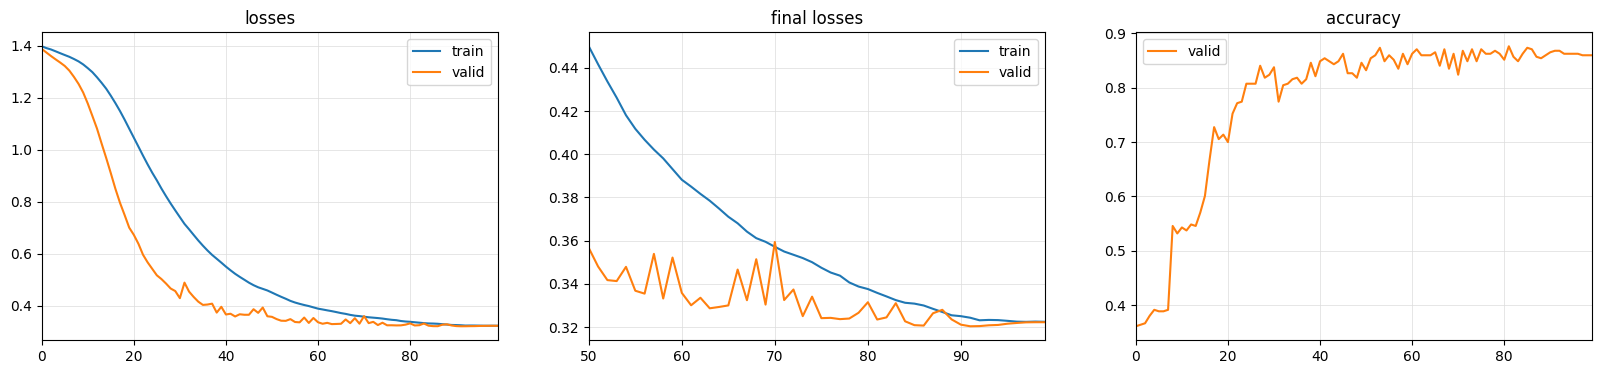

In [ ]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.000398, cbs=ShowGraph())

Оценим точность на тестовом наборе данных

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[2]])
class_map = {
    'winter':3,
    'summer':2,
    'autumn':0,
    'spring':1,
    }
class_map

labeler = ReLabeler(class_map)
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))

0.856353591160221

## Сравнение архитектуры RNNPlus с остальными методами классификации

|model                         |Score RMSE|
|------------------------------|----------|
|RandomForestClassifier        |0.898     |
|KNeighborsTimeSeriesClassifier|0.701     |
|ShapeletTransformClassifier   |0.854     |
|RNNPlus                       |0.856     |

Архитектура RNNPlus показала хороший результат классификации на уровне модели на основе шейплетов. Но недотянула до модели на основе случайного леса.

# Поиск аномалий

Установим необходимые библиотеки

In [ ]:
!pip install adtk

In [ ]:
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import VolatilityShiftAD
from adtk.detector import QuantileAD

##QuantileAD

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


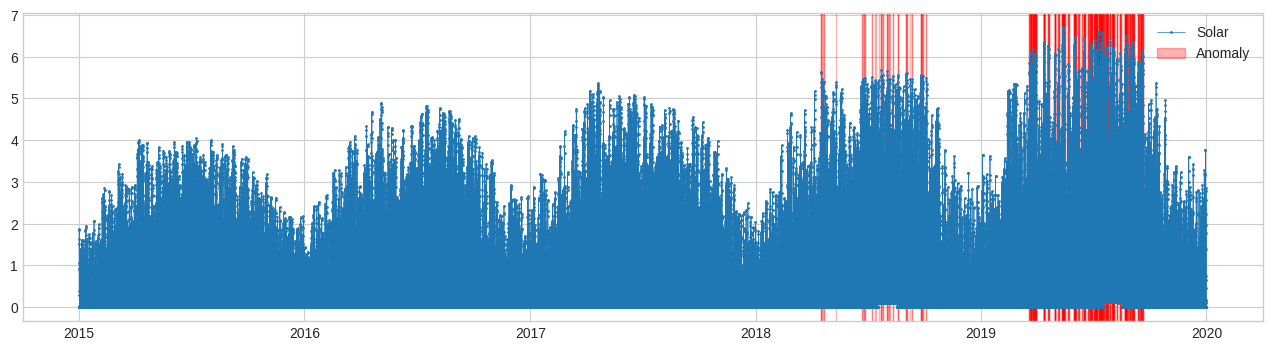

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df.Solar)
plot(df.Solar, anomaly=anomalies, anomaly_color='red', anomaly_tag="span");

QuantileAD сравнивает каждое значение временного ряда с историческими квантилями.
В данном примере определим моменты времени, когда расход солнечной энергии 99% процентиля или ниже 1% процентиля.

Можно заметить что детектор аномалий может ошибаться определяя сезонный рост солнечной энергии как аномалии.

##ThresholdAD

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


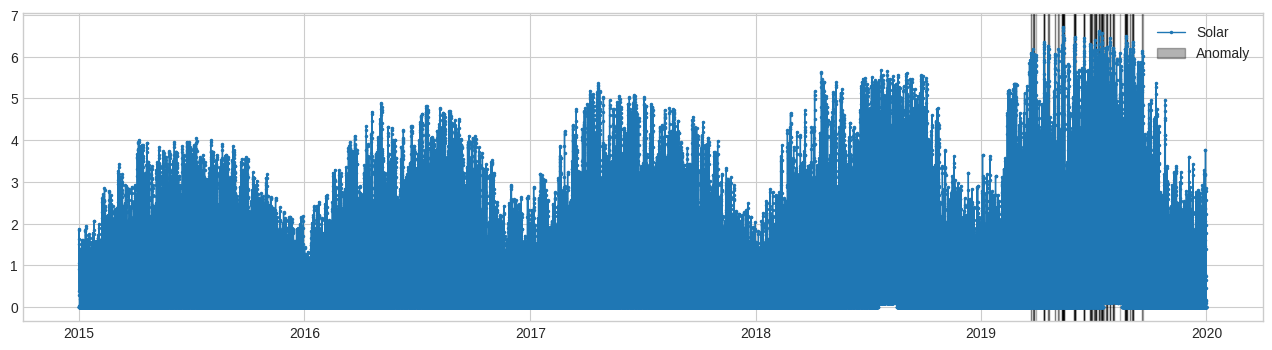

In [ ]:
threshold_val = ThresholdAD(high=6, low=0)
anomalies_thresh = threshold_val.detect(df.Solar)
anomalies_thresh.value_counts()
plot(df.Solar, anomaly=anomalies_thresh, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='black');

Детектор ThresholdAD сравнивает каждое значение временного ряда с заданными пороговыми значениями.

В данном примере определим моменты времени, когда потребление солнечной энергии выше значения 6 или ниже 0.

Данный метод скорее всего подойдет для стабильных данных, когда временное значение не должно быть строго больше или ниже определенного значения.

##VolatilityShiftAD

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


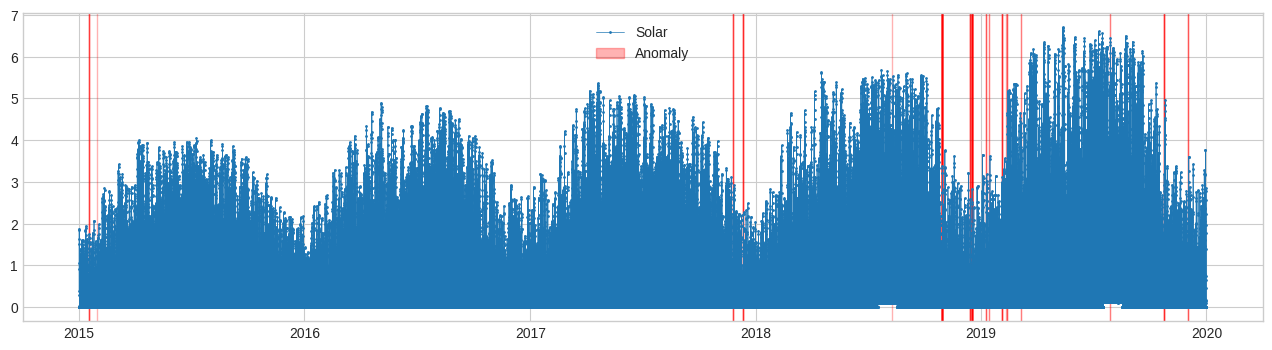

In [ ]:
volatility_shift_ad = VolatilityShiftAD(c=5.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(df.Solar)
plot(df.Solar, anomaly=anomalies, anomaly_color='red');

VolatilityShiftAD обнаруживает сдвиг уровня волатильности, отслеживая разницу между стандартными отклонениями в двух скользящих временных окнах рядом друг с другом.

В данном случае мы обнаруживаем положительный сдвиг волатильности, который указывает на резкое изменение в потреблении солнечной энергии

##Вывод

Причинами появления аномалий связанных с резким изменением потребления солнечной энергии может быть следующее:

- Солнечная активность: В ясные дни, когда солнце ярко светит, производство солнечной энергии возрастает. Это может происходить в результате чистого неба, отсутствия облаков и высокой солнечной активности.

- Увеличение числа солнечных установок: Если количество солнечных установок в какой-то местности было значительно увеличено, это приведет к увеличению общего объема генерируемой солнечной энергии.

- Технологические улучшения: Внедрение более эффективных солнечных технологий и панелей может повысить общую производительность солнечных электростанций.

- Спрос на энергию: Если спрос на энергию резко возрастает, солнечная энергия может быть активно использована в качестве дополнительного источника, чтобы удовлетворить увеличивающиеся потребности.

- Сбой в работе электростчетчиков. Счетчики могут подвергаться техническим сбоям из-за неисправностей в их работе или сбои в программном обеспечении или ошибки в алгоритмах могут привести к некорректному расчету потребления энергии.

Эти факторы могут работать вместе или по отдельности, приводя к резкому увеличению потребления солнечной энергии в определенный период времени.

#Сохранение в формате html

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Итоговый_проект_«Анализ_временных_рядов».ipynb to Итоговый_проект_«Анализ_временных_рядов».ipynb


In [4]:
%%shell
jupyter nbconvert --to html /content/Итоговый_проект_«Анализ_временных_рядов».ipynb

[NbConvertApp] Converting notebook /content/Итоговый_проект_«Анализ_временных_рядов».ipynb to html
[NbConvertApp] Writing 3169305 bytes to /content/Итоговый_проект_«Анализ_временных_рядов».html
